In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torchbnn as bnn

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score as roc_auc_score

from scipy.stats import wasserstein_distance
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *


In [28]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [29]:
def word_to_int(df):
    # Red = 0, blue = 1
    df["class"] = 0
    df_copy = df.copy()
    mask = df_copy["color"] == "blue"
    df.loc[mask, "class"] = 1
    return df

def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [30]:
def fwd_pass_bnn_classifier(net, X:Tensor, y:Tensor, device, optimizer, train=False):
    """
    This function controls the machine learning steps, depending on if we are in training mode or not.
    """
    if train:
        net.train()
        net.zero_grad()
    outputs = net(X.to(device))
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)

    ce_loss = nn.CrossEntropyLoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    kl_weight = 0.1
    ce = ce_loss(outputs, torch.argmax(y,dim=-1).to(device))
    kl = kl_loss(net)
    cost = (ce + kl_weight*kl).to(device)
    if train:
        cost.backward()
        optimizer.step()
    return acc, ce, kl, cost

def train_bnn_classifier(net, traindata, testdata, batchsize:int, epochs:int, device, optimizer, early_stopping:int=-1):
    """
    Trains the model for the number of epochs specified, using the batch size specified.
    Returns a dataframe with the stats from the training.
    """
    dataset = DataLoader(traindata, batchsize, shuffle=True)
    df_labels = ["CE loss", "KL loss", "Cost", "Accuracy", 
                 "Validation CE loss", "Validation KL loss",
                 "Validation cost", "Validation accuracy", 
                 "Epoch", "Iteration"]
    df_created = False # Bool to check if df is created
    #df = pd.DataFrame(dict(zip(df_labels, df_data)))
    i = 0
    patience = early_stopping #How many epochs to keep training if no improvement in validation loss
    min_loss = None
    for epoch in tqdm(range(epochs)):
        # Iterate over batches
        for data in dataset:
            i = i+1
            X, y = data
            #print(X[0], y[0])
            acc, ce_loss, kl_loss, cost = fwd_pass_bnn_classifier(net, X, y, device, optimizer, train=True)
            #acc, loss = test(net, testdata, size=size)
            if i % 10 == 0: #Record every ten batches
                val_acc, val_ce_loss, val_kl_loss, val_cost = test_bnn_classifier(net, testdata, device, optimizer, batchsize)
                df_data = [float(ce_loss), float(kl_loss), float(cost), acc, 
                           float(val_ce_loss), float(val_kl_loss), float(val_cost), val_acc, 
                           epoch, i]
                if df_created == False:
                    df = pd.DataFrame(dict(zip(df_labels, df_data)), index=[0])
                    df_created = True
                else:
                    new_df = pd.DataFrame(dict(zip(df_labels, df_data)), index=[0])
                    df = pd.concat([df, new_df], ignore_index=True)
        #Check every epoch if we should stop
        if ((early_stopping > 0) and df_created): #If small data, we might not have validation loss yet
            if min_loss == None:
                min_loss = float(val_cost)
            elif min_loss <= df["Validation cost"].min():
                patience = patience - 1
            elif min_loss > df["Validation cost"].min():
                min_loss = df["Validation cost"].min()
                patience = early_stopping # Restart early_stopping
            if patience == 0:
                print(f"Stopping training early at epoch {epoch}")
                df.drop([0])
                return df
    df.drop([0])
    return df

def test_bnn_classifier(net, data, device, optimizer, size:int = 32):
    """
    Calculates the accuracy and the loss of the model for a random batch.
    """
    net.eval()
    dataset = DataLoader(data, size, shuffle=True) #shuffle data and choose batch size
    X, y = next(iter(dataset)) #get a random batch
    val_acc, val_ce_loss, val_kl_loss, val_cost = fwd_pass_bnn_classifier(net, X, y, device, optimizer, train=False)
    return val_acc, val_ce_loss, val_kl_loss, val_cost
    
def predict_bnn_classifier(net, testdata, num_classes:int, size:int, device):
    """
    Returns a list of predictions and truth values on testdata.
    It can also return the softmax values of the raw output from the model.
    Does not shuffle the data.
    """
    assert len(testdata)%size==0, "Please choose batch size so that testdata%size==0."

    dataset = DataLoader(testdata, size, shuffle=False) #shuffle data and choose batch size
    probs = torch.zeros((len(dataset), size, num_classes))
    preds = torch.zeros((len(dataset), size))
    truth = torch.zeros((len(dataset), size))
    i = 0
    net.eval()
    with torch.no_grad():
        for data in tqdm(dataset):
            X, y = data
            output = net(X.to(device))
            probs[i] = torch.softmax(output.data, dim=-1)
            
            _, predicted = torch.max(output.data, 1)
            preds[i] = predicted
            truth[i] = torch.argmax(y, dim=-1).to(torch.int)
            i = i+1
    return torch.flatten(preds), torch.flatten(truth), probs.view(-1, num_classes)

In [31]:
# Predict
def predict_bnn(model, dataset, df, device, n_classes=2, n_samples=100):
    
    dataset = DataLoader(dataset, len(dataset), shuffle=False)
    preds = torch.zeros((n_samples, len(df)))
    probs = torch.zeros((n_samples, len(df), n_classes))

    model.eval()
    with torch.no_grad():
        for i in tqdm(range(n_samples)):
            for data in dataset:
                X, y = data
                y = torch.Tensor.float(y)
                pre = model(X.to(device))
                _, predicted = torch.max(pre.data, 1)
                preds[i] = predicted
                probs[i] = torch.softmax(pre.data, dim=-1)

    #total = y.size(0)
    #matches = [i == torch.argmax(j) for i, j in zip(predicted, y)]
    #acc = matches.count(True)/len(matches)
    #print('- Accuracy: %f %%' % (100 * acc))
    #print(len(preds.median(axis=0)))
    df["Prediction_median"] = preds.median(axis=0)[0]
    df["Prediction_mean"] = preds.mean(axis=0)
    
    df["Est_prob_blue"] = probs[:,:,1].mean(axis=0)
    df["Std_prob_blue"] = probs[:,:,1].std(axis=0)

    df["Prediction"] = torch.argmax(probs.mean(axis=0), dim=-1)
    return df


In [32]:
# Set up device
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(0)}")

Using cuda:0 device NVIDIA TITAN V


In [48]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
patience = 70
load_values = True

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nr1MC_4000"
truthfile_test = "analytical_solution_test_n_10000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_nr1MC_8000"
gridfile = f"x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2] # Remove undefined area
truth_test_data = pd.read_csv(f"../analytical/results/{truthfile_test}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

# Prepare data for pytorch
train_data = word_to_int(train_data)
val_data = word_to_int(val_data)
test_data = word_to_int(test_data)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

X_grid = torch.Tensor(np.dstack((grid_data[x1_key], grid_data[x2_key]))).to(torch.float32)[0]
Y_grid = torch.zeros(X_grid.shape)

In [34]:
# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
grid_dataset = torch.utils.data.TensorDataset(X_grid, Y_grid)

In [35]:
# n_train = 250, epochs=250, lr=0.01, batchsize=250
# n_train=1500, epochs=180, lr=0.01, batchsize=2**9
# n_train = 2000, epochs=140, lr=0.05, batchsize=2**9
# n_train = 5000, epochs=180, lr=0.01, batchsize=2**9
# n_train = 10000, epochs=180, lr=0.01, batchsize=2**10

n_data = [250, 5000, 10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
lr_list = [0.01, 0.01, 0.01]
bs_list = [250, 512, 1024]
epochs_list = [1000, 180, 180]


test_dfs = [0]*len(n_data)
grid_dfs = [0]*len(n_data)

In [36]:
for i in range(len(n_data)):

    if load_values==False:
        test_dfs[i] = pd.read_csv(f"../data/{testfile}.csv")
        grid_dfs[i] = pd.read_csv(f"../data/{gridfile}.csv")
        
        model = nn.Sequential(
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2, out_features=200),
            nn.ReLU(),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=200),
            nn.ReLU(),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=200, out_features=2),
        ).to(device)
        
        optimizer = optim.Adam(model.parameters(), lr=lr_list[i])
        n_train = n_data[i]
        epochs = epochs_list[i]
        train_dataset_small = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])
        train_results = train_bnn_classifier(model, train_dataset_small, val_dataset, bs_list[i], epochs, device, optimizer)

        fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 3*3), layout="constrained")
        train_results.plot("Iteration", ["Cost", "Validation cost"], ax=axs[0])
        axs[0].set_ylim(0, 5)
        train_results.plot("Iteration", ["KL loss", "Validation KL loss"], ax=axs[1])
        train_results.plot("Iteration", ["CE loss", "Validation CE loss"], ax=axs[2])
        axs[2].set_ylim(0, 5)

        test_dfs[i] = predict_bnn(model, test_dataset, test_dfs[i], device, n_samples=100)
        grid_dfs[i] = predict_bnn(model, grid_dataset, grid_dfs[i], device, n_samples=100)

        # Save prediction
        if (not os.path.isdir(f"predictions/{trainfile}") ):
            os.mkdir(f"predictions/{trainfile}")
        test_dfs[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_BNN_ndata-{n_data[i]}.csv")
        grid_dfs[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_BNN_ndata-{n_data[i]}.csv")
    else:
        for i in range(len(n_data)):
        #val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
            test_dfs[i] = pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_BNN_ndata-{n_data[i]}.csv")
            grid_dfs[i] = pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_BNN_ndata-{n_data[i]}.csv")


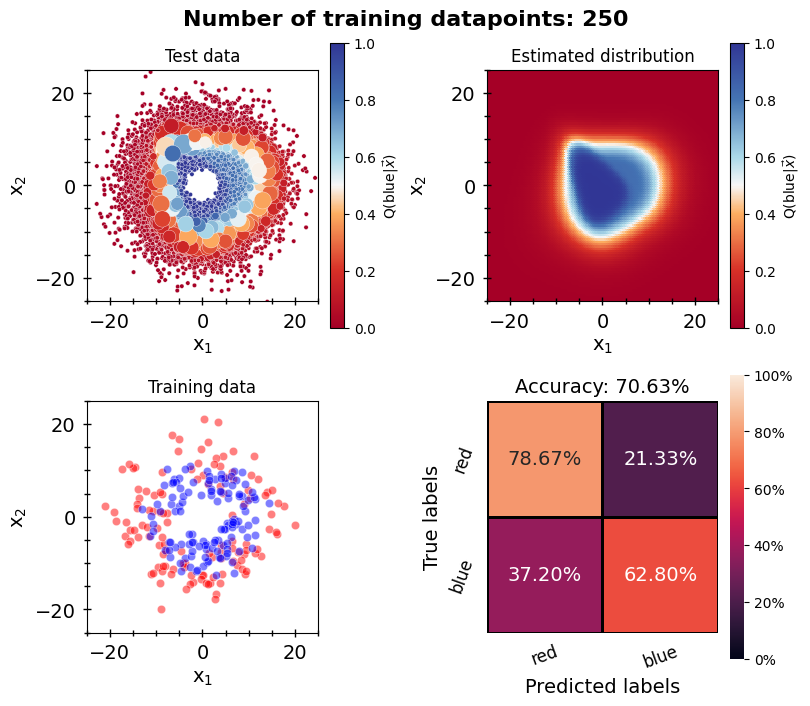

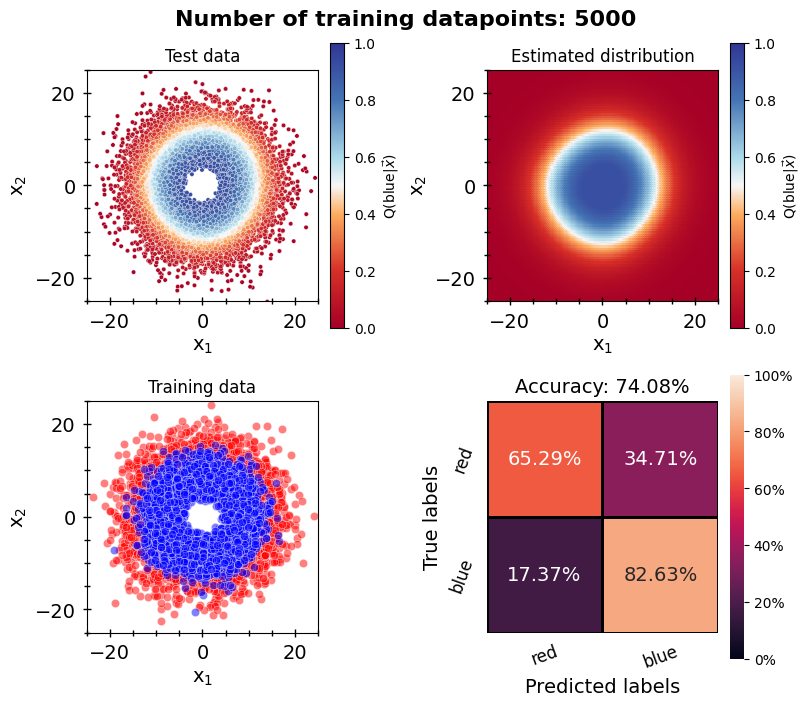

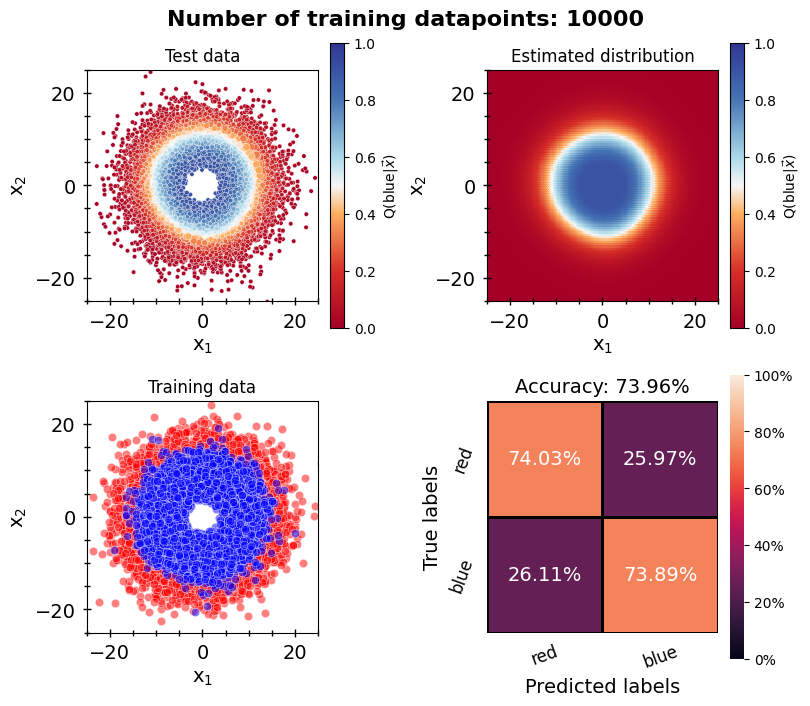

In [37]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(test_dfs[i], "Est_prob_blue", axs[0][0], "Test data", error_key="Std_prob_blue")
    axs[0][1] = plot_results(grid_dfs[i], "Est_prob_blue", axs[0][1], "Estimated distribution", grid=True)
    axs[1][1] = plot_conf_matrix(test_dfs[i], "class", "Prediction", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")


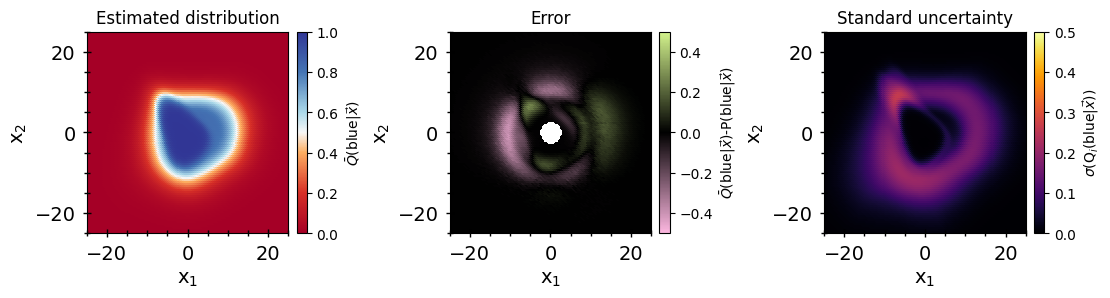

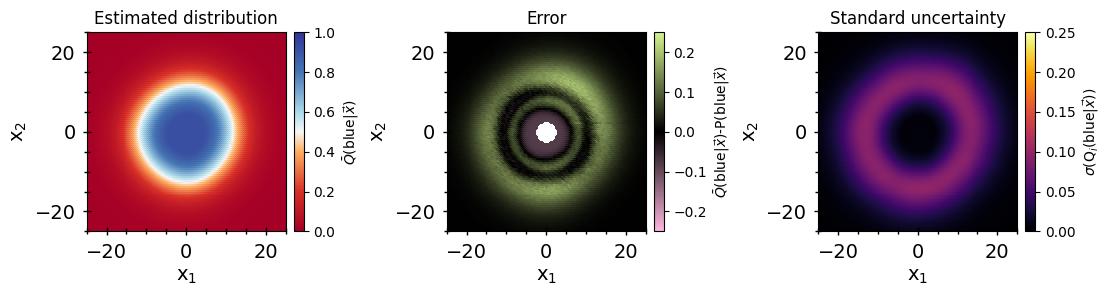

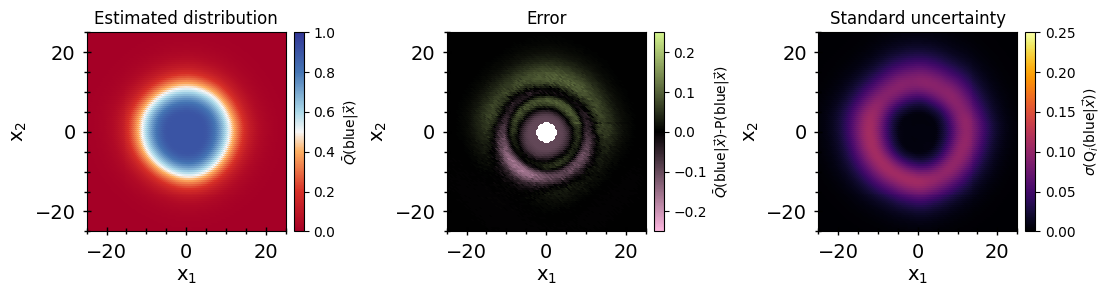

In [38]:
for i in range(len(n_data)):    
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")
    axs[0] = plot_results(grid_dfs[i], "Est_prob_blue", axs[0], "Estimated distribution", grid=True)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()),  fraction=0.050, pad=0.04,
                 label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_dfs[i], truth_data, "Est_prob_blue", "P_blue_given_x", axs[1], r"Error", max_val=max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()),  fraction=0.050, pad=0.04,
                 label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1])

    axs[2] = plot_std(grid_dfs[i], "Std_prob_blue", axs[2], "Standard uncertainty", grid=True, max_val=max_err_val[i])

    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"),  fraction=0.050, pad=0.04,
                 label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2])

    #fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)
    fig.savefig(f"../fig/BNN_ntrain_{n_data[i]}.pdf", format="pdf", bbox_inches='tight', dpi=350)


In [50]:
keys = ["N data"]
scores = pd.DataFrame(columns=keys)
scores["N data"] = n_data
n_plots = len(n_data)
scores["ACC"] = [accuracy_score(test_dfs[i]["class"], test_dfs[i]["Prediction"], normalize=True) for i in range(n_plots)]
scores["ROCAUC"] = [roc_auc_score(test_dfs[i]["class"], test_dfs[i]["Est_prob_blue"]) for i in range(n_plots)]
scores["WD test"] = [wasserstein_distance(truth_test_data["P_blue_given_x"], test_dfs[i]["Est_prob_blue"]) for i in range(len(n_data))]
scores["WD grid"] = [wasserstein_distance(truth_data["P_blue_given_x"], grid_dfs[i]["Est_prob_blue"]) for i in range(len(n_data))]
scores["Avg UE"] = [test_dfs[i]["Std_prob_blue"].mean() for i in range(n_plots)]
scores["Std UE"] = [test_dfs[i]["Std_prob_blue"].std() for i in range(n_plots)]
scores["Mean KL-div test"] = [kl_div(truth_test_data["P_blue_given_x"], test_dfs[i]["Est_prob_blue"]).mean() for i in range(len(n_data))]
scores["Mean KL-div grid"] = [kl_div(truth_data["P_blue_given_x"], grid_dfs[i]["Est_prob_blue"]).mean() for i in range(len(n_data))]
scores["LogLoss"] = [log_loss(test_dfs[i]["class"], test_dfs[i]["Est_prob_blue"]) for i in range(len(n_data))]

print(scores)

   N data     ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0     250  0.7063  0.794628  0.074320  0.016679  0.115465  0.054942   
1    5000  0.7408  0.819355  0.054793  0.051142  0.058963  0.025757   
2   10000  0.7396  0.819527  0.037634  0.018863  0.068232  0.029883   

   Mean KL-div test  Mean KL-div grid   LogLoss  
0          0.053699          0.014793  0.573812  
1          0.018875          0.013422  0.523715  
2          0.015216          0.002875  0.516850  


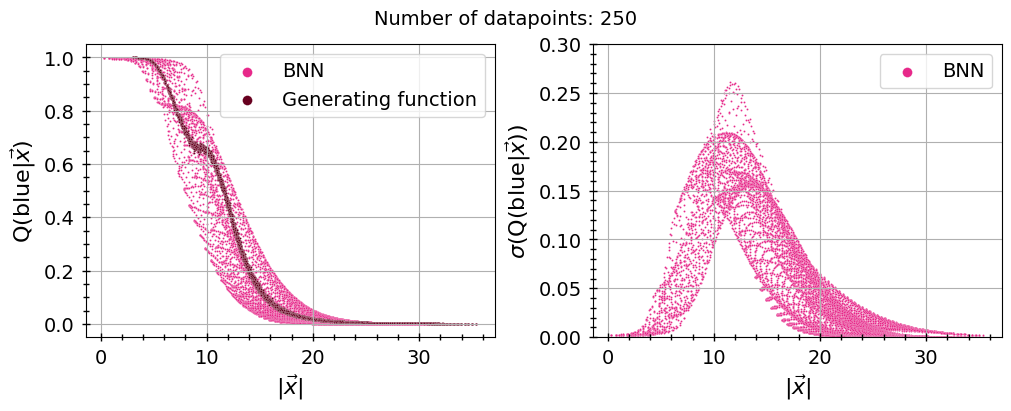

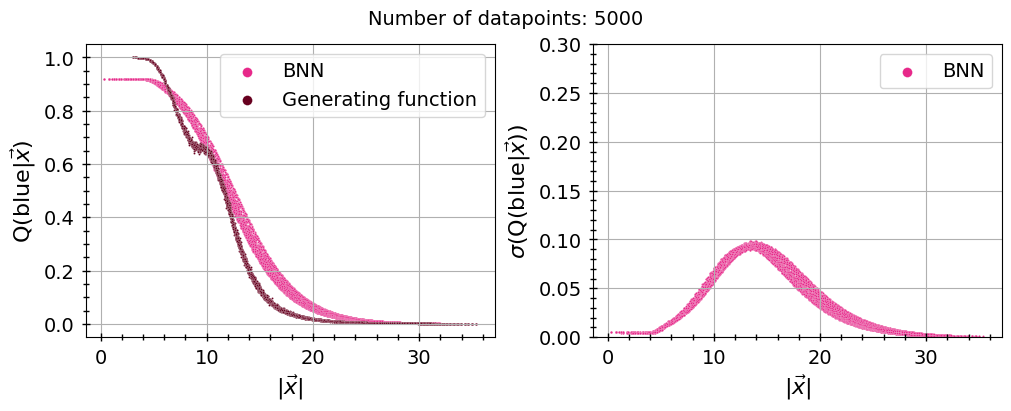

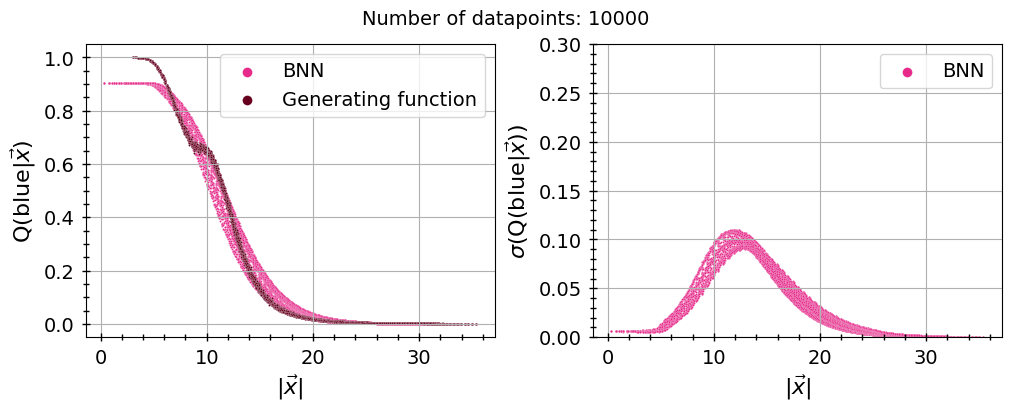

In [40]:
for i in range(len(n_data)): 
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_dfs[i], x="r_x", y="Est_prob_blue", s=2, ax = axs[0], label="BNN", color="#e7298a")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label="Generating function", color="#67001f")
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_dfs[i], x="r_x", y="Std_prob_blue", s=2, ax = axs[1], label="BNN", color="#e7298a")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.3)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_data[i]}", fontsize=14)

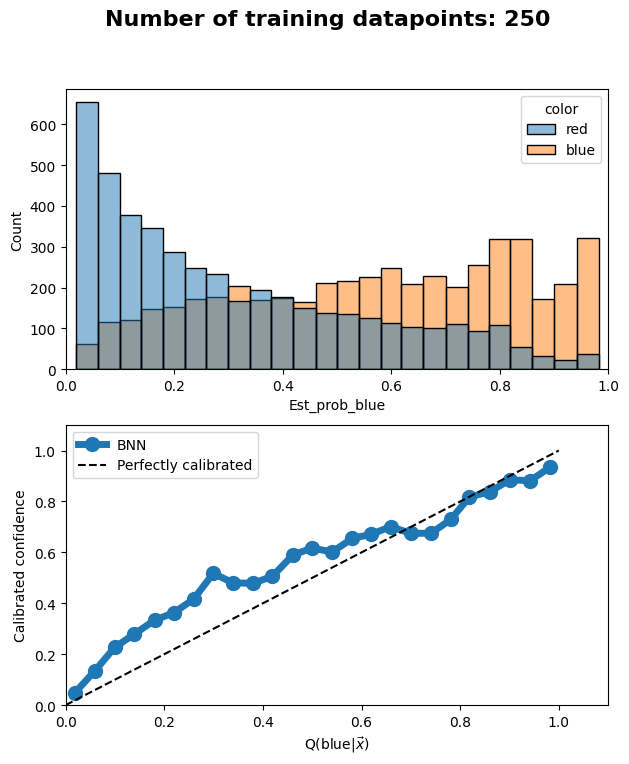

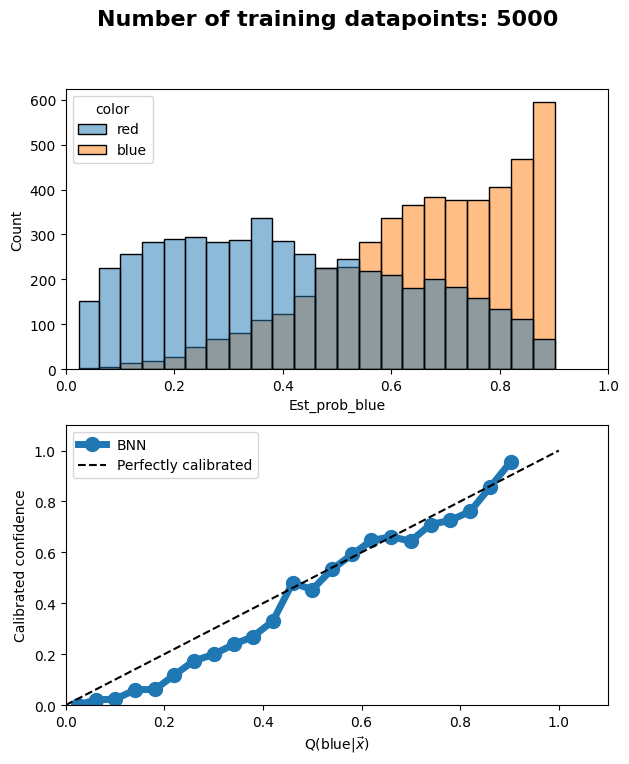

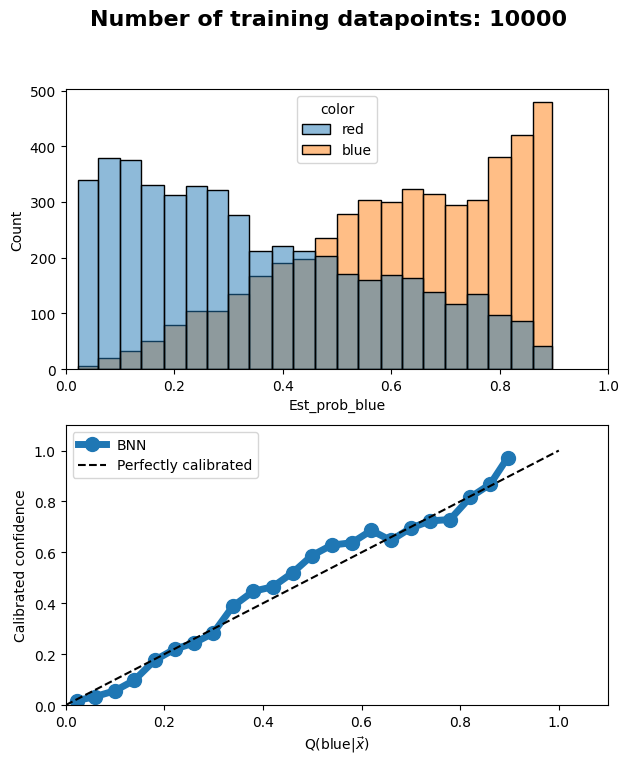

In [41]:
for i in range(len(n_data)): 

    prob_cal, prob_pred = calibration_curve(test_dfs[i]["class"], test_dfs[i]["Est_prob_blue"], n_bins=25, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))
    sn.histplot(test_dfs[i], x="Est_prob_blue", hue="color", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="BNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel(r"Q(blue|$\vec{x}$)")
    ax[1].set_ylabel("Calibrated confidence")
    ax[1].legend()
    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")